<h1><b>Task 1 - API processing pipeline (not finished)<b><h1>

In [11]:
import cv2
import numpy as np
import pandas as pd
import warnings
import random
warnings.filterwarnings('ignore')
import src.proprietary_functions as src
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [12]:
# Setting filepaths
annotation_file = './sample_data/Anno/'

identity_file = annotation_file + 'identity_CelebA.txt'

# Train/test split variables
random_seed = 123
test_size = 0.2
validation_size = 0.2

bbox_col_names = {
    'x_start' : 'x_1',
    'y_start' : 'y_1',
    'width' : 'width',
    'height' : 'height',
    'x_end' : '',
    'y_end' : ''}


# Loading dataset metadata
identity = pd.read_csv(identity_file, sep=" ", header = None,names=['image', 'image_id'])

#Filtering faces that appear at least 20 times (to reduce the execution time)
labels_annot = pd.DataFrame(identity.image_id.value_counts(ascending=True)).query('image_id > 20').index.tolist()
identity_filtered = identity[identity['image_id'].isin(labels_annot)]

#Train/test split of the annotations
imgs = identity_filtered['image']
labels = identity_filtered['image_id']

temp_imgs, test_imgs, _, __ = train_test_split(imgs, labels,
                                               test_size = test_size,
                                               random_state = random_seed,        
                                               stratify = labels)
train_imgs, valid_imgs, _, __ = train_test_split(temp_imgs, _,
                                               test_size = validation_size/(1-test_size),
                                               random_state = random_seed,        
                                               stratify = _)


In [13]:
#creating a dataframe with paths to the images with their labels
temp = pd.DataFrame(train_imgs).merge(identity_filtered, on = 'image')
temp['image'] = './data/Img/img_celeba/' + temp['image']

#separating the images and labels and then creating a TF dataset.
pics = temp['image'].values
labels = temp['image_id'].values

dataset = tf.data.Dataset.from_tensor_slices((pics, labels))

In [14]:
#Displaying 1st observation of the dataset
for d in dataset.take(1):
    display(d)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/Img/img_celeba/028972.jpg'>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6949>)

In [15]:
#printing the last observation, particularly the last image path as a tensor
print(d[0]) 

tf.Tensor(b'./data/Img/img_celeba/028972.jpg', shape=(), dtype=string)


In [16]:
#printing the last image path as numpy (byte string) by converting it from tensor
print(d[0].numpy())

b'./data/Img/img_celeba/028972.jpg'


In [17]:
#decoding the byte string to utf-8 -> therefore, we would assume that this logic will work when mapping a custom function.
print(d[0].numpy().decode('utf-8'))

./data/Img/img_celeba/028972.jpg


In [37]:
#Unfortunately, it doesn't work. According to several sources, we would extract the string path by numpy() method to the tensor. However, it shows an error that tensor doesnt have a numpy object.
#we tried another approach such as using tf.io.read_file() and tf.image_decode_jpeg() which would be input to the bounding box generator from cv2 library. Though, this neither doesnt work as well.

def process_images(filename, label):
    
    bbox_col_names = {
                        'x_start' : 'x_1',
                        'y_start' : 'y_1',
                        'width' : 'width',
                        'height' : 'height',
                        'x_end' : '',
                        'y_end' : ''}
        
    def bbox_engine(pic, m1_scale_factor = 1.1, m1_min_neighbors = 13):
        h = tf.io.read_file(pic)
        i = tf.image.decode_jpeg(h)
        img = np.array(i)
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(image = img, scaleFactor = m1_scale_factor, minNeighbors = m1_min_neighbors)
        while len(faces) < 1:
            m1_min_neighbors -= 1
            faces = face_cascade.detectMultiScale(image = img, scaleFactor =m1_scale_factor, minNeighbors = m1_min_neighbors)
            if m1_min_neighbors < 0:
                break
    
        if len(faces) > 0:

            bbox = {
                    "x_1" : faces[0][0],
                    "y_1" : faces[0][1],
                    "width" : faces[0][2],
                    "height" : faces[0][3],
                    'x_end' : faces[0][0] + faces[0][2],
                    'y_end' : faces[0][1] + faces[0][3]}

            return bbox
    
    bbox_coordinates = bbox_engine(filename)
    bbox_generated = pd.DataFrame(columns= ['image_id', 'x_1', 'y_1', 'width', 'height', 'x_end', 'y_end'])

    if bbox_coordinates != None:
        bbox_coordinates['image_id'] =tf.io.read_file(filename)
        bbox_generated = bbox_generated.append(bbox_coordinates, ignore_index = True)
        startX = bbox_generated[bbox_generated['image_id'] ==tf.io.read_file(filename)][bbox_col_names['x_start']].values[0]
        startY = bbox_generated[bbox_generated['image_id'] == tf.io.read_file(filename)][bbox_col_names['y_start']].values[0]
        endX = startX + bbox_generated[bbox_generated['image_id'] ==tf.io.read_file(filename)][bbox_col_names['width']].values[0]
        endY = startY + bbox_generated[bbox_generated['image_id'] ==tf.io.read_file(filename)][bbox_col_names['height']].values[0]
        img =  cv2.imread(tf.io.read_file(filename))
        crop_img = cv2.resize(img[startY:endY, startX:endX], (224, 224))
        crop_img =tf.convert_to_tensor(crop_img, dtype=tf.float32)
    else:
        crop_img = np.zeros(shape = (224, 224, 3))
        crop_img = tf.convert_to_tensor(crop_img, dtype=tf.float32)

    return crop_img, label
dataset = dataset.map(process_images)

NotImplementedError: in user code:

    File "/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_57455/3480843803.py", line 17, in bbox_engine  *
        img = np.array(i)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (DecodeJpeg:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [38]:
#Unfortunately, it doesn't work. According to several sources, we would extract the string path by numpy() method to the tensor. However, it shows an error that tensor doesnt have a numpy object.
#we tried another approach such as using tf.io.read_file() and tf.image_decode_jpeg() which would be input to the bounding box generator from cv2 library. Though, this neither doesnt work as well.

def process_images(filename, label):
    
    bbox_col_names = {
                        'x_start' : 'x_1',
                        'y_start' : 'y_1',
                        'width' : 'width',
                        'height' : 'height',
                        'x_end' : '',
                        'y_end' : ''}
        
    def bbox_engine(pic, m1_scale_factor = 1.1, m1_min_neighbors = 13):
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(image = img, scaleFactor = m1_scale_factor, minNeighbors = m1_min_neighbors)
        while len(faces) < 1:
            m1_min_neighbors -= 1
            faces = face_cascade.detectMultiScale(image = img, scaleFactor =m1_scale_factor, minNeighbors = m1_min_neighbors)
            if m1_min_neighbors < 0:
                break
    
        if len(faces) > 0:

            bbox = {
                    "x_1" : faces[0][0],
                    "y_1" : faces[0][1],
                    "width" : faces[0][2],
                    "height" : faces[0][3],
                    'x_end' : faces[0][0] + faces[0][2],
                    'y_end' : faces[0][1] + faces[0][3]}

            return bbox
    
    bbox_coordinates = bbox_engine(filename.numpy().decode('utf-8'))
    bbox_generated = pd.DataFrame(columns= ['image_id', 'x_1', 'y_1', 'width', 'height', 'x_end', 'y_end'])
    if bbox_coordinates != None:
        bbox_coordinates['image_id'] = filename.numpy().decode('utf-8')
        bbox_generated = bbox_generated.append(bbox_coordinates, ignore_index = True)
        startX = bbox_generated[bbox_generated['image_id'] == filename.numpy().decode('utf-8')][bbox_col_names['x_start']].values[0]
        startY = bbox_generated[bbox_generated['image_id'] == filename.numpy().decode('utf-8')][bbox_col_names['y_start']].values[0]
        endX = startX + bbox_generated[bbox_generated['image_id'] == filename.numpy().decode('utf-8')][bbox_col_names['width']].values[0]
        endY = startY + bbox_generated[bbox_generated['image_id'] == filename.numpy().decode('utf-8')][bbox_col_names['height']].values[0]
        img =  cv2.imread(filename.numpy().decode('utf-8'))
        crop_img = cv2.resize(img[startY:endY, startX:endX], (224, 224))
        crop_img =tf.convert_to_tensor(crop_img, dtype=tf.float32)

    else:
        crop_img = np.zeros(shape = (224, 224, 3))
        crop_img = tf.convert_to_tensor(crop_img, dtype=tf.float32)

    return crop_img, label
dataset = dataset.map(process_images)

AttributeError: in user code:

    File "/var/folders/jm/t_0fgqb560d3w58nyxy1qmy00000gn/T/ipykernel_57455/3208490349.py", line 36, in process_images  *
        bbox_coordinates = bbox_engine(filename.numpy().decode('utf-8'))

    AttributeError: 'Tensor' object has no attribute 'numpy'


<h1><b>Task 2 and 3 - evaluation and classification<b><h1>

In [20]:
photo_initials = ['PN','DM','PH','RP','NM']
photo_names = [i+'_'+j for i in photo_initials for j in [str(i) for i in range(1,5)]]

In [21]:
#list for storing the cropped photos
data = []
#cropping the photos for each member
bbox_generated = pd.DataFrame(columns= ['image_id', 'x_1', 'y_1', 'width', 'height', 'x_end', 'y_end'])
for init_name in photo_initials:
    for num in [str(i) for i in range(1,5)]:
        bbox_coordinates = src.bbox_engine_img_input(f'{init_name}_{num}.jpg', './team_photos/')
        bbox_coordinates['image_id'] = f'{init_name}_{num}.jpg'
        bbox_generated = bbox_generated.append(bbox_coordinates, ignore_index = True)
        startX = bbox_generated[bbox_generated['image_id'] == f'{init_name}_{num}.jpg'][bbox_col_names['x_start']].values[0]
        startY = bbox_generated[bbox_generated['image_id'] == f'{init_name}_{num}.jpg'][bbox_col_names['y_start']].values[0]
        endX = startX + bbox_generated[bbox_generated['image_id'] == f'{init_name}_{num}.jpg'][bbox_col_names['width']].values[0]
        endY = startY + bbox_generated[bbox_generated['image_id'] == f'{init_name}_{num}.jpg'][bbox_col_names['height']].values[0]
        img =  cv2.imread( './team_photos/'+ f'{init_name}_{num}.jpg')
        crop_img = cv2.resize(img[startY:endY, startX:endX], (224, 224))
        data.append(crop_img)

In [22]:
#train test split (1st two photos will be in the training set, the last two will be in the test set)
annotations = [num for num, _ in enumerate(photo_initials)]
labels = [annot for annot in annotations for i in range(0,4)]
train_ind = []
test_ind = []
for i, phot in enumerate(photo_names):
    if phot.split('_')[1] in (['3','4']):
        test_ind.append(i)
    else:
        train_ind.append(i)

data_train = [data[i] for i in train_ind]
y_train = [labels[i] for i in train_ind]
data_test = [data[i] for i in test_ind]
y_test = [labels[i] for i in test_ind]


y_train = np.array(y_train)
y_test = np.array(y_test)
data_test = np.array(data_test)
data_train = np.array(data_train)

In [23]:
#function from Viktor
def sort_labels_by_classes(labs):
    result = []
    for i in range(len(photo_initials)):
        result.append(np.where(labs == i)[0])
    return result

train_classes = sort_labels_by_classes(y_train)
test_classes = sort_labels_by_classes(y_test)

#number of classes per sample
print(len(train_classes))
print(len(test_classes))

5
5


In [24]:
#function from Viktor
def create_triplets(data, labels):
    triplets_data = []
    class_count = len(photo_initials)
    # go per each of cloth class
    for i in range(len(labels)):
        # class for processing
        class_label_length = len(labels[i])
        # go for each of item in current cloth class
        for j in range(class_label_length - 1):
            # get the positive pair - n and n+1 item from current label
            idx1, idx2 = labels[i][j], labels[i][j + 1]
            # random generate increment from 1-9 to add to current class index
            inc = random.randrange(1, class_count)
            # add increment to class index and apply modulo by class count to get random negative class label index
            negative_label_index = (i + inc) % class_count
            # take random item from other label items to create a negative pair
            negative_sample = random.choice(labels[negative_label_index])
            # save negative pair and set label to 0
            triplets_data.append([data[idx1], data[idx2], data[negative_sample]])
    # numpy arrays are easier to work with, so type list into it
    return np.array(triplets_data)

X_train = create_triplets(data_train, train_classes)
X_test = create_triplets(data_test, test_classes)

print(X_train.shape)
print(X_test.shape)

(5, 3, 224, 224, 3)
(5, 3, 224, 224, 3)


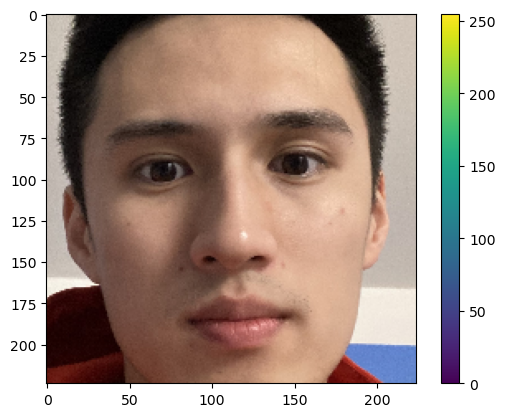

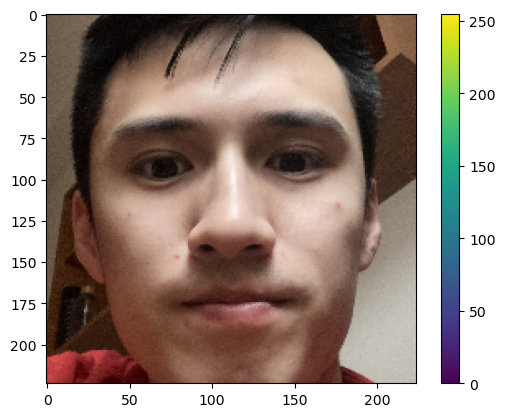

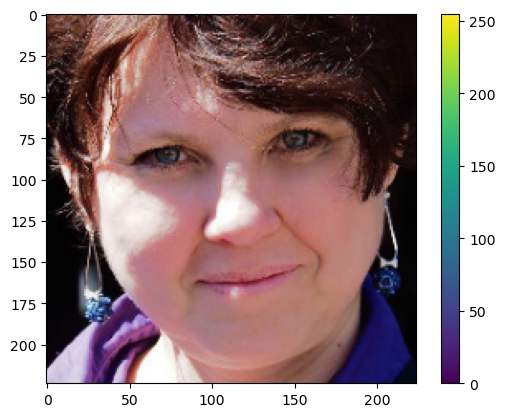

In [25]:
def show_image(image):
    plt.figure()
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.colorbar()
    plt.grid(False)
    plt.show()

triplet = 0
# show images at this index
show_image(X_train[triplet][0])
show_image(X_train[triplet][1])
show_image(X_train[triplet][2])

In [26]:
def initialize_base_network():
    input = Input(shape=(224,224,3))
    x = Flatten()(input)
    x = Dense(1200, activation='relu')(x)
    x = Dense(1200, activation='relu')(x)
    x = Dense(1200, activation='relu')(x)
    return Model(inputs=input, outputs=x)

In [27]:
embedding = initialize_base_network()
tf.keras.utils.plot_model(embedding, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [28]:
class SiameseNet(tf.keras.layers.Layer):
    # set the backbone model in constructor
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, feat):
        # get feature vectors from anchor
        feats = self.model(feat[0])
        # from positive image
        pfeats = self.model(feat[1])
        # and from negative image
        nfeats = self.model(feat[2])
        # concatenate vectors to a matrix
        result = tf.stack([feats, pfeats, nfeats])
        return result

class TripletLoss(tf.keras.layers.Layer):
    # margin is settable hyperparameter in constructor
    def __init__(self, margin):
        self.margin = margin
        super().__init__()
        
    # function calculating distance between features
    def distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

    def call(self, features):
        # get anchor-positive distance
        pos = self.distance(features[0], features[1])
        # anchor-negative distance
        neg = self.distance(features[0], features[2])
        # difference between anchor positive and anchor negative distances
        loss = pos - neg
        # get overall loss
        return tf.maximum(loss + self.margin, 0.0)

In [29]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(abs(y_true-y_pred))

In [30]:
# anchor branch
image_input = Input(shape=(224,224,3), name='image_input')
# positive image branch
positive_input = Input(shape=(224,224,3), name='positive_input')
# negative image branch
negative_input = Input(shape=(224,224,3), name='negative_input')

siamese = SiameseNet(embedding)([image_input, positive_input, negative_input])
loss = TripletLoss(margin=1.0)(siamese)
model = Model(inputs=[image_input, positive_input, negative_input], outputs=loss)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = identity_loss)

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [32]:
history = model.fit([X_train[:,0], X_train[:,1], X_train[:,2]], np.ones(X_train.shape[0]),
            batch_size=128, verbose=1,
            validation_data=([X_test[:,0], X_test[:,1], X_test[:,2]], np.ones(X_test.shape[0])),
            epochs=20)

Epoch 1/20
1/1 [==============================] - 4s 4s/step - loss: 202.0716 - val_loss: 5303.4116
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 12937.6143 - val_loss: 6615.7905
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 858.3750 - val_loss: 8305.2793
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 1.0000 - val_loss: 9285.9248
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 1.0000 - val_loss: 11314.0752
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 1.0000 - val_loss: 13752.6465
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 1.0000 - val_loss: 15593.8359
Epoch 8/20
1/1 [==============================] - 3s 3s/step - loss: 1.0000 - val_loss: 17295.0703
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 1.0000 - val_loss: 19025.5898
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 1.0000 - val_loss: 20889.9941
Epoch

In [ ]:
#as can be observed, we have an overfitting which is mainly caused by very limited and small number of photos in training set.

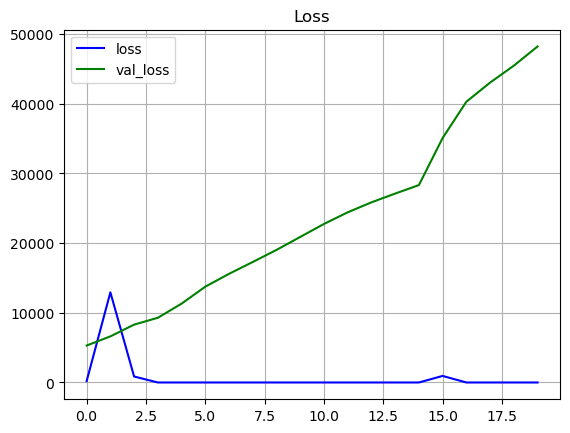

In [33]:
def plot_metrics(metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.grid()
    plt.legend()
plot_metrics(metric_name='loss', title="Loss")

In [34]:
#Viktor's function
def create_pairs(data, labels):
    pairs_data = []
    pairs_labels = []
    ids = []
    class_count = len(photo_initials)

    # go per each of cloth class
    for i in range(len(labels)):
        # class for processing
        class_label_length = len(labels[i])
        # go for each of item in current cloth class
        for j in range(class_label_length - 1):
            # get the positive pair - n and n+1 item from current label
            idx1, idx2 = labels[i][j], labels[i][j + 1]
            # save to list and set label to 1
            pairs_data.append([data[idx1], data[idx2]])
            pairs_labels.append(1.0)
            ids.append([i, i])

            # random generate increment from 1-9 to add to current class index
            inc = random.randrange(1, class_count)
            # add increment to class index and apply modulo by class count to get random negative class label index
            negative_label_index = (i + inc) % class_count
            # take random item from other label items to create a negative pair
            negative_sample = random.choice(labels[negative_label_index])
            # save negative pair and set label to 0
            pairs_data.append([data[idx1], data[negative_sample]])
            pairs_labels.append(0.0)
            ids.append([i, negative_label_index])

    # numpy arrays are easier to work with, so type list into it
    return np.array(pairs_data), np.array(pairs_labels), np.array(ids)
# %%
X_test, Y_test, ids = create_pairs(data_test, test_classes)
left_pair = X_test[:,0]
left_pair_pred = embedding.predict(left_pair)
right_pair = X_test[:,1]
right_pair_pred = embedding.predict(right_pair)

1/1 [==============================] - 0s 91ms/step


In [35]:
#Accuracy calcuation from Viktor's notebook
def compute_accuracy(left_pair_pred, right_pair_pred, y_true):
    y_pred = np.linalg.norm(left_pair_pred - right_pair_pred, axis=1)
#     # 1 for the same - distance is smaller than 3.0, 0 for the different
    pred = y_pred < 7.0
    return np.mean(pred == y_true)

test_accuracy = compute_accuracy(embedding.predict(X_test[:,0]), embedding.predict(X_test[:,1]), Y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

1/1 [==============================] - 0s 75ms/step
Test accuracy: 50.00%


In [ ]:
#Model as 50% accuracy and as can be seen in the confusion matrix below, it classifies all the pairs as positive and none as negative.

In [36]:
#Confusion matrix
preds = (np.linalg.norm(left_pair_pred - right_pair_pred, axis=1) < 7.0)
confusion_matrix(Y_test, preds)

array([[5, 0],
       [5, 0]])